### Install required packages and Set random seeds for reproducibility

In [ ]:

!pip install tensorflow scikit-learn matplotlib seaborn pandas numpy kagglehub

import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import os
import time


np.random.seed(42)
tf.random.set_seed(42)

print("✅ Packages imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

✅ Packages imported successfully!
TensorFlow version: 2.19.0


### Download dataset using kagglehub

In [ ]:

print("📥 Downloading dataset...")
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print(f"📁 Dataset path: {path}")

# Explore dataset structure
def explore_dataset(path):
    print("\n📊 Dataset structure:")
    total_images = 0
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')

        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]
        if image_files:
            subindent = ' ' * 2 * (level + 1)
            print(f'{subindent}📷 Images: {len(image_files)}')
            total_images += len(image_files)
    print(f"\n📈 Total images found: {total_images}")
    return total_images

total_images = explore_dataset(path)

📥 Downloading dataset...
Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
📁 Dataset path: /kaggle/input/brain-tumor-mri-dataset

📊 Dataset structure:
brain-tumor-mri-dataset/
  Training/
    pituitary/
      📷 Images: 1457
    notumor/
      📷 Images: 1595
    meningioma/
      📷 Images: 1339
    glioma/
      📷 Images: 1321
  Testing/
    pituitary/
      📷 Images: 300
    notumor/
      📷 Images: 405
    meningioma/
      📷 Images: 306
    glioma/
      📷 Images: 300

📈 Total images found: 7023


### Data preparation

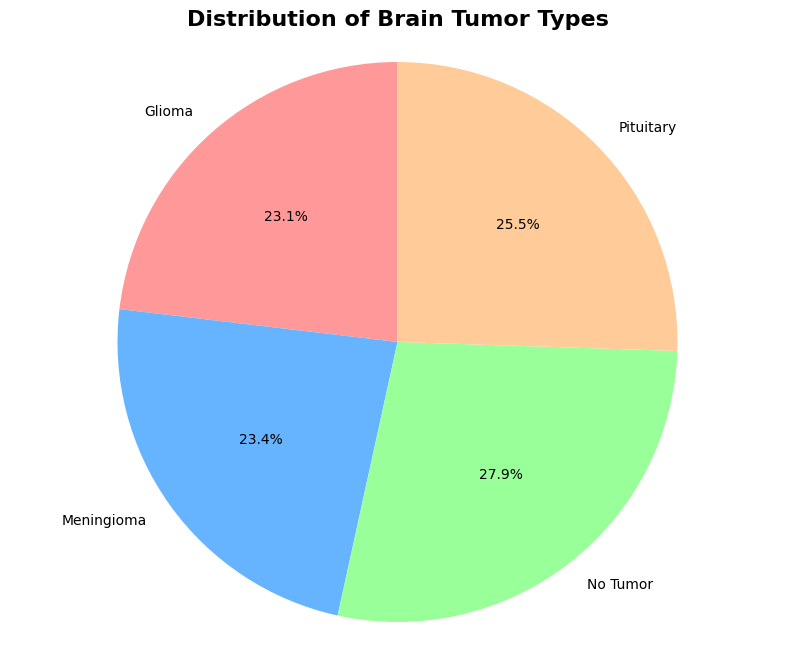

📊 Class Distribution:
  glioma: 1321 images
  meningioma: 1339 images
  notumor: 1595 images
  pituitary: 1457 images


In [ ]:

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Count images in each class
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(path, 'Training', class_name)
    class_counts[class_name] = len(os.listdir(class_path))

# Create pie chart
plt.figure(figsize=(10, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
plt.pie(class_counts.values(), labels=class_labels, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Distribution of Brain Tumor Types', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

print("📊 Class Distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} images")

### Enhanced Data Preprocessing

In [ ]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 64  # Increased batch size for faster training

# Medical imaging specific augmentation
def create_medical_augmentation():
    return ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,  # Reduced for medical images
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1],
        fill_mode='constant',
        cval=0,  # Fill with black
        validation_split=0.2
    )

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_datagen = create_medical_augmentation()

train_generator = train_datagen.flow_from_directory(
    os.path.join(path, 'Training'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(path, 'Training'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(path, 'Testing'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✅ Data generators created:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {val_generator.samples}")
print(f"   Testing samples: {test_generator.samples}")

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
✅ Data generators created:
   Training samples: 4571
   Validation samples: 1141
   Testing samples: 1311


### Display sample images

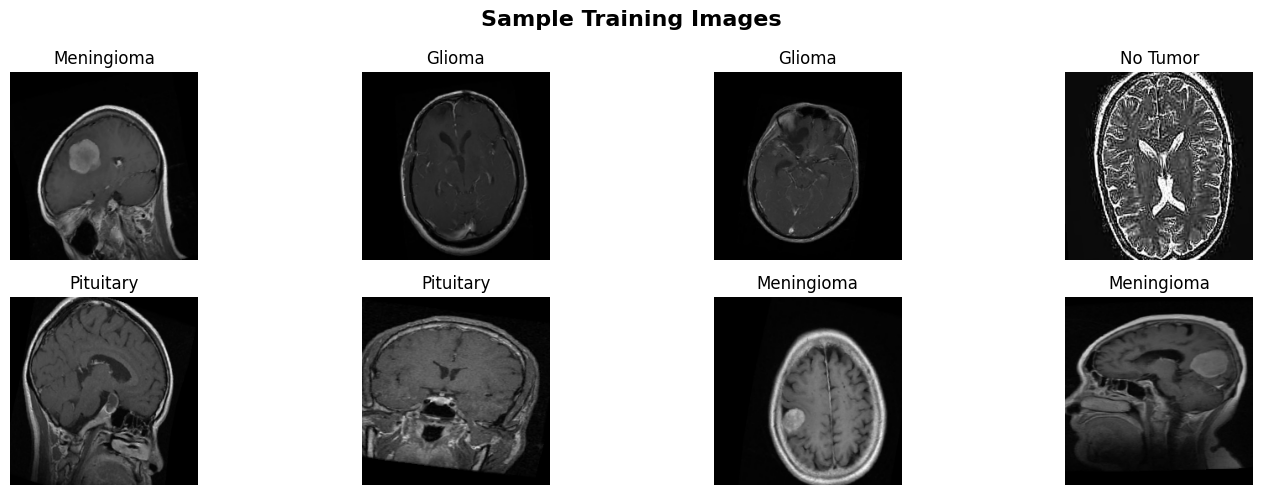

In [ ]:

def display_sample_images(generator, title):
    plt.figure(figsize=(15, 5))
    images, labels = next(generator)

    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        class_idx = np.argmax(labels[i])
        plt.title(f'{class_labels[class_idx]}')
        plt.axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

display_sample_images(train_generator, 'Sample Training Images')

### Selecting 4 Best Fast Models

In [ ]:
def create_efficientnet_b0():
    """Very efficient with good accuracy - Best Balance"""
    base_model = tf.keras.applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(4, activation='softmax')
    ])
    return model

def create_mobilenet_v2():
    """Fast and lightweight - Good for Mobile"""
    base_model = tf.keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(4, activation='softmax')
    ])
    return model

def create_efficientnet_v2_s():
    """Latest EfficientNet - Highest Accuracy"""
    base_model = tf.keras.applications.EfficientNetV2S(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(4, activation='softmax')
    ])
    return model

def create_lightweight_cnn():
    """Fastest Training - Custom Architecture"""
    model = tf.keras.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        # Classifier
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(4, activation='softmax')
    ])
    return model

print("✅ 4 Best Fast Models Defined:")
print("   1. EfficientNetB0 - Best Balance")
print("   2. MobileNetV2 - Fast & Lightweight")
print("   3. EfficientNetV2S - Highest Accuracy")
print("   4. LightweightCNN - Fastest Training")

✅ 4 Best Fast Models Defined:
   1. EfficientNetB0 - Best Balance
   2. MobileNetV2 - Fast & Lightweight
   3. EfficientNetV2S - Highest Accuracy
   4. LightweightCNN - Fastest Training


### Enhanced Training Configuration

In [ ]:

EPOCHS = 40  # Reduced epochs for faster training
INITIAL_LR = 0.001

# Advanced Callbacks
def create_advanced_callbacks(model_name):
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=12,
            restore_best_weights=True,
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=6,
            min_lr=1e-7,
            mode='max'
        ),
        tf.keras.callbacks.ModelCheckpoint(
            f'best_{model_name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        )
    ]

# Compile model
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Class weight balancing
def calculate_class_weights(generator):
    from sklearn.utils.class_weight import compute_class_weight
    classes = generator.classes
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(classes),
        y=classes
    )
    return dict(enumerate(class_weights))

class_weights = calculate_class_weights(train_generator)
print("📊 Class weights calculated:", class_weights)

📊 Class weights calculated: {0: np.float64(1.0811258278145695), 1: np.float64(1.0659981343283582), 2: np.float64(0.8955721003134797), 3: np.float64(0.9800600343053173)}


### Training Functions

In [ ]:
models_dict = {}
histories = {}
training_times = {}
results = {}

def train_model_fast(model, model_name, train_gen, val_gen, epochs=EPOCHS):
    print(f"\n{'='*60}")
    print(f"🚀 Training {model_name}")
    print(f"{'='*60}")

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=create_advanced_callbacks(model_name),
        class_weight=class_weights,
        verbose=1
    )
    return history

def train_efficientnet_b0():
    print("🔄 Initializing EfficientNetB0...")
    model = create_efficientnet_b0()
    model = compile_model(model)

    start_time = time.time()
    history = train_model_fast(model, 'EfficientNetB0', train_generator, val_generator)
    training_time = time.time() - start_time

    model.save('EfficientNetB0_brain_tumor.keras')
    histories['EfficientNetB0'] = history
    training_times['EfficientNetB0'] = training_time
    models_dict['EfficientNetB0'] = model

    return model, history, training_time

def train_mobilenet_v2():
    print("🔄 Initializing MobileNetV2...")
    model = create_mobilenet_v2()
    model = compile_model(model)

    start_time = time.time()
    history = train_model_fast(model, 'MobileNetV2', train_generator, val_generator)
    training_time = time.time() - start_time

    model.save('MobileNetV2_brain_tumor.keras')
    histories['MobileNetV2'] = history
    training_times['MobileNetV2'] = training_time
    models_dict['MobileNetV2'] = model

    return model, history, training_time

def train_efficientnet_v2_s():
    print("🔄 Initializing EfficientNetV2S...")
    model = create_efficientnet_v2_s()
    model = compile_model(model)

    start_time = time.time()
    history = train_model_fast(model, 'EfficientNetV2S', train_generator, val_generator)
    training_time = time.time() - start_time

    model.save('EfficientNetV2S_brain_tumor.keras')
    histories['EfficientNetV2S'] = history
    training_times['EfficientNetV2S'] = training_time
    models_dict['EfficientNetV2S'] = model

    return model, history, training_time

def train_lightweight_cnn():
    print("🔄 Initializing LightweightCNN...")
    model = create_lightweight_cnn()
    model = compile_model(model)

    start_time = time.time()
    history = train_model_fast(model, 'LightweightCNN', train_generator, val_generator, epochs=30)
    training_time = time.time() - start_time

    model.save('LightweightCNN_brain_tumor.keras')
    histories['LightweightCNN'] = history
    training_times['LightweightCNN'] = training_time
    models_dict['LightweightCNN'] = model

    return model, history, training_time

print("✅ Individual training functions created!")
print("\n🎯 Train models in this order for best results:")
print("1. train_lightweight_cnn()  - Fastest (5-10 min)")
print("2. train_mobilenet_v2()     - Fast (10-15 min)")
print("3. train_efficientnet_b0()  - Balanced (15-20 min)")
print("4. train_efficientnet_v2_s() - Accurate (20-25 min)")

✅ Individual training functions created!

🎯 Train models in this order for best results:
1. train_lightweight_cnn()  - Fastest (5-10 min)
2. train_mobilenet_v2()     - Fast (10-15 min)
3. train_efficientnet_b0()  - Balanced (15-20 min)
4. train_efficientnet_v2_s() - Accurate (20-25 min)


### Evaluation Functions

In [ ]:

def evaluate_single_model(model, model_name, test_gen):
    print(f"\n{'='*50}")
    print(f"📊 Evaluating {model_name}")
    print(f"{'='*50}")

    # Get predictions
    y_pred = model.predict(test_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    cm = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes,
                                 target_names=class_labels, output_dict=True)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(f'{model_name} - Confusion Matrix\nAccuracy: {accuracy:.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    }

    print(f"✅ {model_name} Test Accuracy: {accuracy:.4f}")
    return accuracy, cm, report

# Individual evaluation functions
def evaluate_efficientnet_b0():
    if 'EfficientNetB0' in models_dict:
        return evaluate_single_model(models_dict['EfficientNetB0'], 'EfficientNetB0', test_generator)
    else:
        print("EfficientNetB0 not trained yet.")

def evaluate_mobilenet_v2():
    if 'MobileNetV2' in models_dict:
        return evaluate_single_model(models_dict['MobileNetV2'], 'MobileNetV2', test_generator)
    else:
        print("MobileNetV2 not trained yet.")

def evaluate_efficientnet_v2_s():
    if 'EfficientNetV2S' in models_dict:
        return evaluate_single_model(models_dict['EfficientNetV2S'], 'EfficientNetV2S', test_generator)
    else:
        print("EfficientNetV2S not trained yet.")

def evaluate_lightweight_cnn():
    if 'LightweightCNN' in models_dict:
        return evaluate_single_model(models_dict['LightweightCNN'], 'LightweightCNN', test_generator)
    else:
        print("LightweightCNN not trained yet.")

### Training History Visualization

In [ ]:

def plot_single_model_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax2.set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    print(f"📈 {model_name} - Final Val Accuracy: {final_val_acc:.4f}, Best: {best_val_acc:.4f}")

def plot_all_histories():
    available_models = [model for model in ['EfficientNetB0', 'MobileNetV2', 'EfficientNetV2S', 'LightweightCNN']
                       if model in histories]

    if not available_models:
        print("No training histories available.")
        return

    n_models = len(available_models)
    fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 10))

    if n_models == 1:
        axes = axes.reshape(2, 1)

    for i, model_name in enumerate(available_models):
        history = histories[model_name]

        # Loss
        axes[0, i].plot(history.history['loss'], label='Train Loss')
        axes[0, i].plot(history.history['val_loss'], label='Val Loss')
        axes[0, i].set_title(f'{model_name} - Loss')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)

        # Accuracy
        axes[1, i].plot(history.history['accuracy'], label='Train Acc')
        axes[1, i].plot(history.history['val_accuracy'], label='Val Acc')
        axes[1, i].set_title(f'{model_name} - Accuracy')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Final Results and Comparison

In [ ]:

def create_final_comparison():
    if not results:
        print("No results available. Please train and evaluate models first.")
        return

    # Create performance table
    performance_table = pd.DataFrame({
        'Model': list(results.keys()),
        'Test Accuracy': [results[model]['accuracy'] for model in results.keys()],
        'Training Time (min)': [training_times[model]/60 for model in results.keys()],
        'Parameters (M)': [models_dict[model].count_params()/1e6 for model in results.keys()]
    })

    # Sort by accuracy
    performance_table = performance_table.sort_values('Test Accuracy', ascending=False)

    print("\n" + "="*70)
    print("🏆 FINAL MODEL COMPARISON")
    print("="*70)
    print(performance_table.round(4))

    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy comparison
    models = performance_table['Model']
    accuracies = performance_table['Test Accuracy']
    bars1 = ax1.bar(models, accuracies, color=['#2E8B57', '#4169E1', '#FF8C00', '#DC143C'][:len(models)])
    ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1.0)
    ax1.grid(axis='y', alpha=0.3)

    for bar, acc in zip(bars1, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

    # Training time comparison
    times = performance_table['Training Time (min)']
    bars2 = ax2.bar(models, times, color=['#2E8B57', '#4169E1', '#FF8C00', '#DC143C'][:len(models)])
    ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Time (minutes)')
    ax2.grid(axis='y', alpha=0.3)

    for bar, time_val in zip(bars2, times):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{time_val:.1f}m', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print summary
    best_model = performance_table.iloc[0]
    print(f"\n🎯 BEST MODEL: {best_model['Model']}")
    print(f"   Accuracy: {best_model['Test Accuracy']:.4f} ({best_model['Test Accuracy']*100:.2f}%)")
    print(f"   Training Time: {best_model['Training Time (min)']:.1f} minutes")
    print(f"   Parameters: {best_model['Parameters (M)']:.1f}M")

    return performance_table

# Utility function to check status
def check_training_status():
    trained_models = list(models_dict.keys())
    evaluated_models = list(results.keys())

    print("\n📋 TRAINING STATUS:")
    print(f"   Models Trained: {trained_models}")
    print(f"   Models Evaluated: {evaluated_models}")

    if trained_models:
        print(f"\n⏱️  Training Times:")
        for model, time_val in training_times.items():
            print(f"   {model}: {time_val/60:.1f} minutes")

    return trained_models, evaluated_models

### Lightweight CNN

🔄 Initializing LightweightCNN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🚀 Training LightweightCNN


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5999 - loss: 0.9371 - val_accuracy: 0.2550 - val_loss: 4.4657 - learning_rate: 0.0010
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7457 - loss: 0.6471 - val_accuracy: 0.2550 - val_loss: 13.5566 - learning_rate: 0.0010
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8223 - loss: 0.4652 - val_accuracy: 0.2550 - val_loss: 9.2511 - learning_rate: 0.0010
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8468 - loss: 0.4291 - val_accuracy: 0.2550 - val_loss: 8.4225 - learning_rate: 0.0010
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8583 - loss: 0.4037 - val_accuracy: 0.3848 - val_loss: 3.2695 - learning_rate: 0.0010
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8627 - loss: 0.3813 - val_accuracy: 0.5819 - val_loss: 1.4254 - learning_rate: 0.0010
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8926 - loss: 0.3099 - val_accuracy

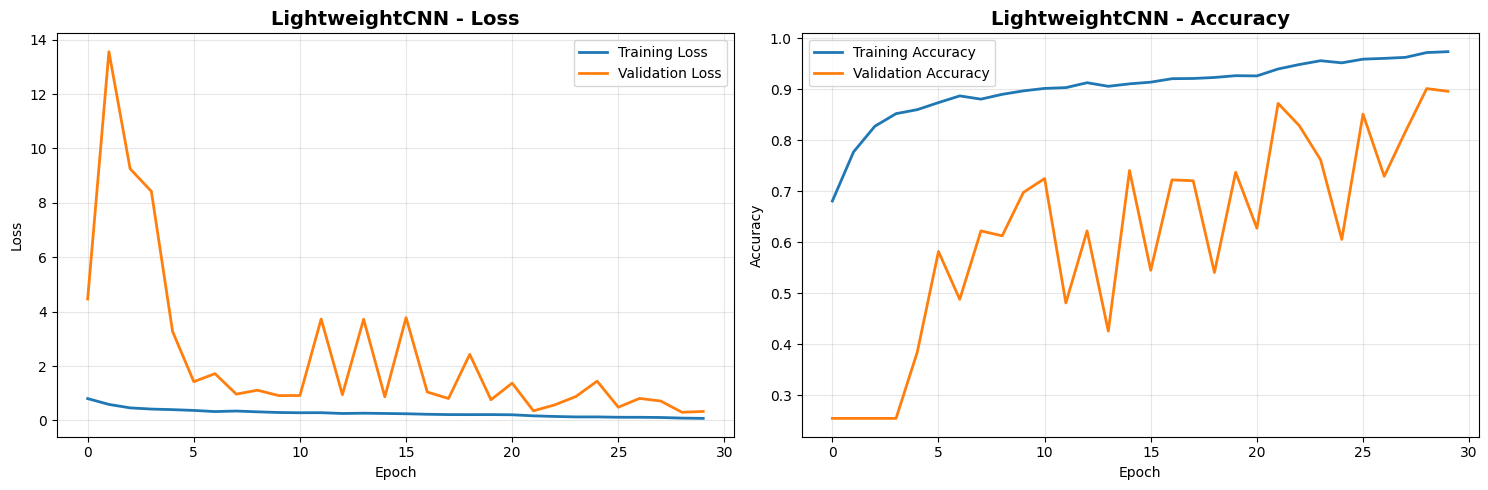

📈 LightweightCNN - Final Val Accuracy: 0.8957, Best: 0.9010

📊 Evaluating LightweightCNN
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 608ms/step


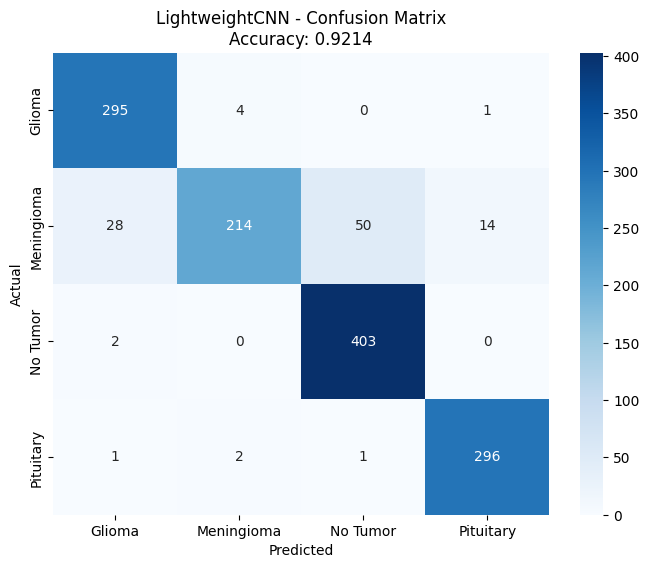

✅ LightweightCNN Test Accuracy: 0.9214


(0.9214340198321892,
 array([[295,   4,   0,   1],
        [ 28, 214,  50,  14],
        [  2,   0, 403,   0],
        [  1,   2,   1, 296]]),
 {'Glioma': {'precision': 0.9049079754601227,
   'recall': 0.9833333333333333,
   'f1-score': 0.9424920127795527,
   'support': 300.0},
  'Meningioma': {'precision': 0.9727272727272728,
   'recall': 0.6993464052287581,
   'f1-score': 0.8136882129277566,
   'support': 306.0},
  'No Tumor': {'precision': 0.8876651982378855,
   'recall': 0.9950617283950617,
   'f1-score': 0.9383003492433062,
   'support': 405.0},
  'Pituitary': {'precision': 0.9517684887459807,
   'recall': 0.9866666666666667,
   'f1-score': 0.9689034369885434,
   'support': 300.0},
  'accuracy': 0.9214340198321892,
  'macro avg': {'precision': 0.9292672337928154,
   'recall': 0.916102033405955,
   'f1-score': 0.9158460029847897,
   'support': 1311.0},
  'weighted avg': {'precision': 0.9261341647618003,
   'recall': 0.9214340198321892,
   'f1-score': 0.9171768646299475,
   'support

In [ ]:

model1, history1, time1 = train_lightweight_cnn()
plot_single_model_history(history1, 'LightweightCNN')
evaluate_lightweight_cnn()



### MobileNetV2

🔄 Initializing MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

🚀 Training MobileNetV2
Epoch 1/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.7364 - loss: 0.7228 - val_accuracy: 0.7607 - val_loss: 0.6629 - learning_rate: 0.0010
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9014 - loss: 0.2833 - val_accuracy: 0.8265 - val_loss: 0.4682 - learning_rate: 0.0010
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9030 - loss: 0.2650 - val_accuracy: 0.8273 - val_loss: 0.4451 - learning_rate: 0.0010
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9151 - loss: 0.2378 - val_accuracy: 0.8221 - val_loss: 0.4950 - learning_rate: 0.0010
Epoch 5/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9253 - loss: 0.2188 - val_accuracy: 0.8379 - val_loss: 0.4507 - learning_rate: 0.0010
Epoch 6/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9347 - loss: 0.1938 - val_accuracy: 0.8422 - val_loss: 0.4555 - learning_rate: 0.0

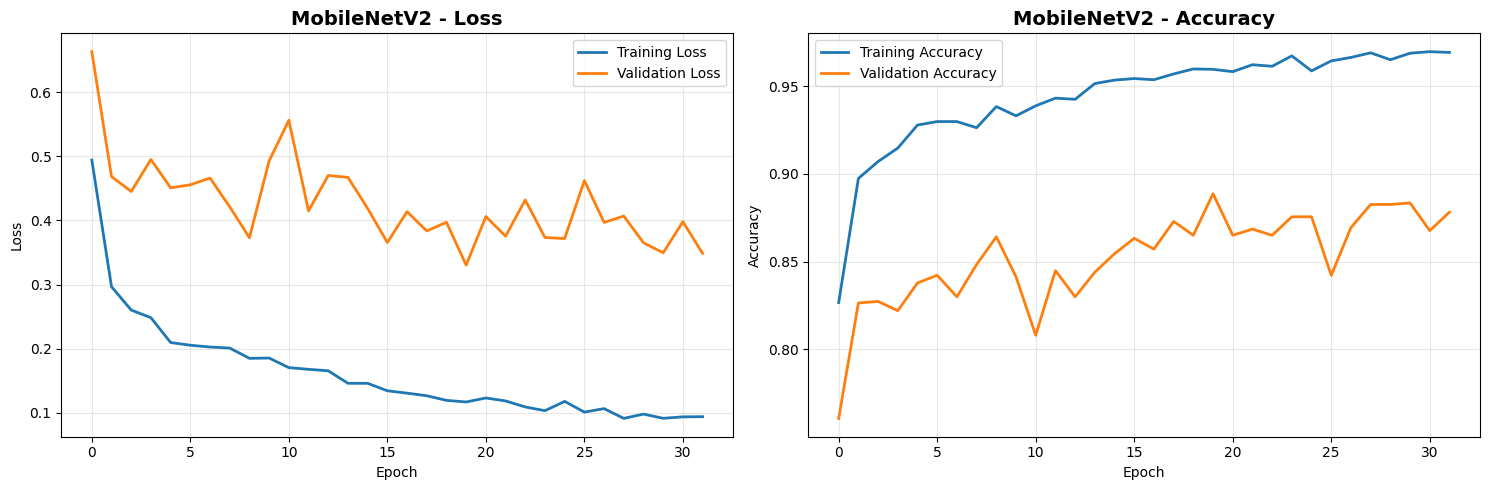

📈 MobileNetV2 - Final Val Accuracy: 0.8782, Best: 0.8887

📊 Evaluating MobileNetV2
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 724ms/step


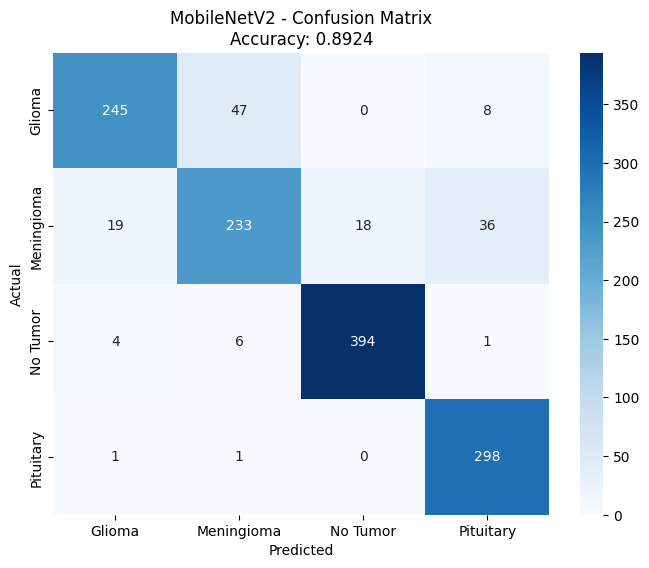

✅ MobileNetV2 Test Accuracy: 0.8924


(0.8924485125858124,
 array([[245,  47,   0,   8],
        [ 19, 233,  18,  36],
        [  4,   6, 394,   1],
        [  1,   1,   0, 298]]),
 {'Glioma': {'precision': 0.9107806691449815,
   'recall': 0.8166666666666667,
   'f1-score': 0.8611599297012302,
   'support': 300.0},
  'Meningioma': {'precision': 0.8118466898954704,
   'recall': 0.761437908496732,
   'f1-score': 0.7858347386172007,
   'support': 306.0},
  'No Tumor': {'precision': 0.9563106796116505,
   'recall': 0.9728395061728395,
   'f1-score': 0.9645042839657283,
   'support': 405.0},
  'Pituitary': {'precision': 0.8688046647230321,
   'recall': 0.9933333333333333,
   'f1-score': 0.926905132192846,
   'support': 300.0},
  'accuracy': 0.8924485125858124,
  'macro avg': {'precision': 0.8869356758437836,
   'recall': 0.8860693536673928,
   'f1-score': 0.8846010211192513,
   'support': 1311.0},
  'weighted avg': {'precision': 0.8921483695737121,
   'recall': 0.8924485125858124,
   'f1-score': 0.8905485763472206,
   'support'

In [ ]:

model2, history2, time2 = train_mobilenet_v2()
plot_single_model_history(history2, 'MobileNetV2')
evaluate_mobilenet_v2()



### EfficientNetB0

🔄 Initializing EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

🚀 Training EfficientNetB0
Epoch 1/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.2706 - loss: 1.5099 - val_accuracy: 0.2340 - val_loss: 1.4470 - learning_rate: 0.0010
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.3137 - loss: 1.4047 - val_accuracy: 0.2314 - val_loss: 1.4089 - learning_rate: 0.0010
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.3535 - loss: 1.3451 - val_accuracy: 0.2358 - val_loss: 1.4551 - learning_rate: 0.0010
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.3889 - loss: 1.2873 - val_accuracy: 0.2323 - val_loss: 1.7691 - learning_rate: 0.0010
Epoch 5/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.3796 - loss: 1.2658 - val_accuracy: 0.2568 - val_loss: 1.7331 - learning_rate: 0.0010
Epoch 6/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.3932 - loss: 1.2484 - val_accuracy: 0.3602 - val_loss: 1.4727 - learning_r

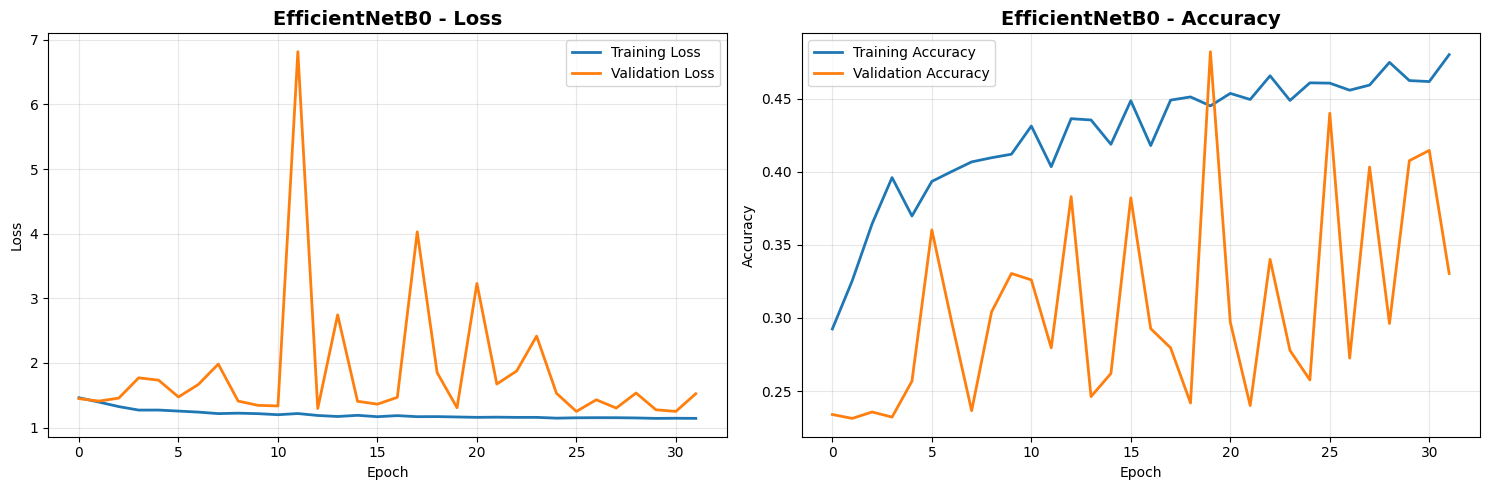

📈 EfficientNetB0 - Final Val Accuracy: 0.3304, Best: 0.4820

📊 Evaluating EfficientNetB0
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 753ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


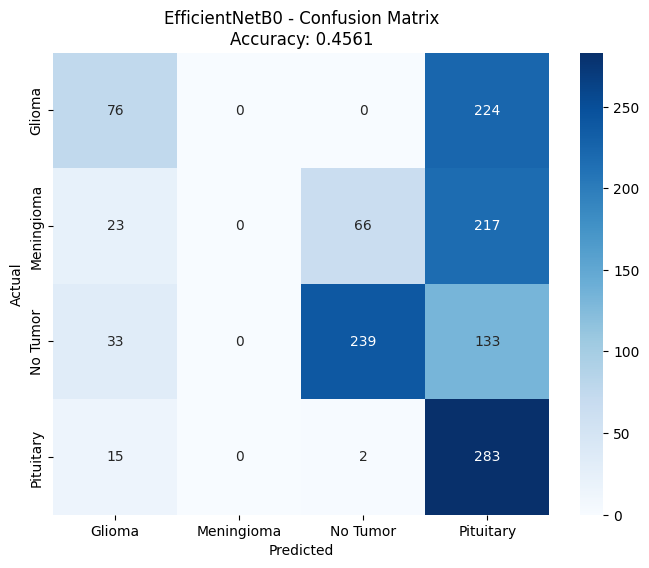

✅ EfficientNetB0 Test Accuracy: 0.4561


(0.45614035087719296,
 array([[ 76,   0,   0, 224],
        [ 23,   0,  66, 217],
        [ 33,   0, 239, 133],
        [ 15,   0,   2, 283]]),
 {'Glioma': {'precision': 0.5170068027210885,
   'recall': 0.25333333333333335,
   'f1-score': 0.3400447427293065,
   'support': 300.0},
  'Meningioma': {'precision': 0.0,
   'recall': 0.0,
   'f1-score': 0.0,
   'support': 306.0},
  'No Tumor': {'precision': 0.7785016286644951,
   'recall': 0.5901234567901235,
   'f1-score': 0.6713483146067416,
   'support': 405.0},
  'Pituitary': {'precision': 0.33022170361726955,
   'recall': 0.9433333333333334,
   'f1-score': 0.4891961970613656,
   'support': 300.0},
  'accuracy': 0.45614035087719296,
  'macro avg': {'precision': 0.4064325337507133,
   'recall': 0.44669753086419756,
   'f1-score': 0.37514731359935344,
   'support': 1311.0},
  'weighted avg': {'precision': 0.43437201488224864,
   'recall': 0.45614035087719296,
   'f1-score': 0.3971535845560122,
   'support': 1311.0}})

In [14]:
model3, history3, time3 = train_efficientnet_b0()
plot_single_model_history(history3, 'EfficientNetB0')
evaluate_efficientnet_b0()



### EfficientNetV2S

🔄 Initializing EfficientNetV2S...
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

🚀 Training EfficientNetV2S
Epoch 1/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.5234 - loss: 1.2251 - val_accuracy: 0.5443 - val_loss: 1.1784 - learning_rate: 0.0010
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6216 - loss: 0.9085 - val_accuracy: 0.5460 - val_loss: 1.1221 - learning_rate: 0.0010
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6349 - loss: 0.8729 - val_accuracy: 0.4890 - val_loss: 1.1136 - learning_rate: 0.0010
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6503 - loss: 0.8683 - val_accuracy: 0.5337 - val_loss: 1.0885 - learning_rate: 0.0010
Epoch 5/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.6647 - loss: 0.8391 - val_accuracy: 0.5609 - val_loss: 1.1145 - learning_rate: 0.0010
Epoch 6/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.6504 - loss: 0.8446 - val_accuracy: 0.5977 - val_loss: 0.9780 - learning

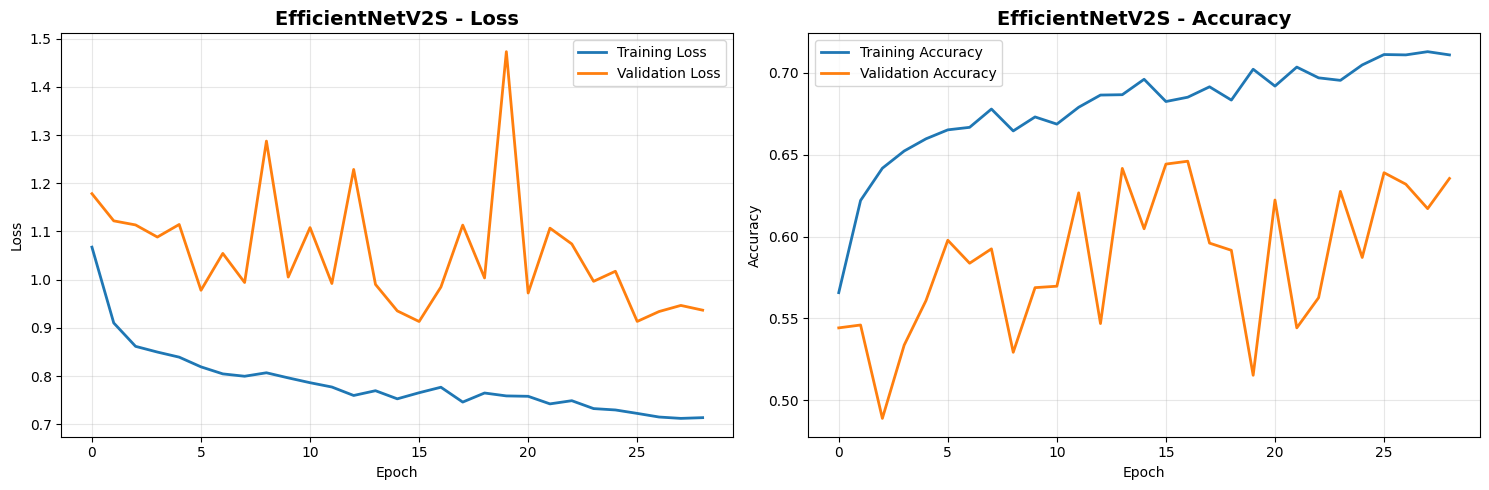

📈 EfficientNetV2S - Final Val Accuracy: 0.6354, Best: 0.6459

📊 Evaluating EfficientNetV2S
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step


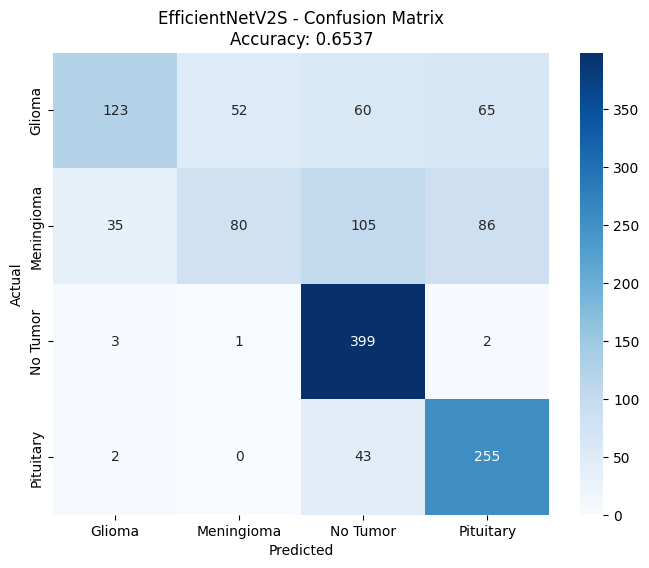

✅ EfficientNetV2S Test Accuracy: 0.6537


(0.6536994660564455,
 array([[123,  52,  60,  65],
        [ 35,  80, 105,  86],
        [  3,   1, 399,   2],
        [  2,   0,  43, 255]]),
 {'Glioma': {'precision': 0.754601226993865,
   'recall': 0.41,
   'f1-score': 0.531317494600432,
   'support': 300.0},
  'Meningioma': {'precision': 0.6015037593984962,
   'recall': 0.26143790849673204,
   'f1-score': 0.36446469248291574,
   'support': 306.0},
  'No Tumor': {'precision': 0.657331136738056,
   'recall': 0.9851851851851852,
   'f1-score': 0.7885375494071146,
   'support': 405.0},
  'Pituitary': {'precision': 0.625,
   'recall': 0.85,
   'f1-score': 0.7203389830508474,
   'support': 300.0},
  'accuracy': 0.6536994660564455,
  'macro avg': {'precision': 0.6596090307826044,
   'recall': 0.6266557734204793,
   'f1-score': 0.6011646798853274,
   'support': 1311.0},
  'weighted avg': {'precision': 0.6591606627406651,
   'recall': 0.6536994660564455,
   'f1-score': 0.6150883651449562,
   'support': 1311.0}})

In [15]:
model4, history4, time4 = train_efficientnet_v2_s()
plot_single_model_history(history4, 'EfficientNetV2S')
evaluate_efficientnet_v2_s()

### Training status check

In [ ]:
check_training_status()


📋 TRAINING STATUS:
   Models Trained: ['LightweightCNN', 'MobileNetV2', 'EfficientNetB0', 'EfficientNetV2S']
   Models Evaluated: ['LightweightCNN', 'MobileNetV2', 'EfficientNetB0', 'EfficientNetV2S']

⏱️  Training Times:
   LightweightCNN: 43.0 minutes
   MobileNetV2: 44.9 minutes
   EfficientNetB0: 45.2 minutes
   EfficientNetV2S: 43.7 minutes


(['LightweightCNN', 'MobileNetV2', 'EfficientNetB0', 'EfficientNetV2S'],
 ['LightweightCNN', 'MobileNetV2', 'EfficientNetB0', 'EfficientNetV2S'])

### Final Results


🏆 FINAL MODEL COMPARISON
             Model  Test Accuracy  Training Time (min)  Parameters (M)
0   LightweightCNN         0.9214              42.9523          0.4895
1      MobileNetV2         0.8924              44.9302          2.4230
3  EfficientNetV2S         0.6537              43.7133         20.6613
2   EfficientNetB0         0.4561              45.2206          4.4119


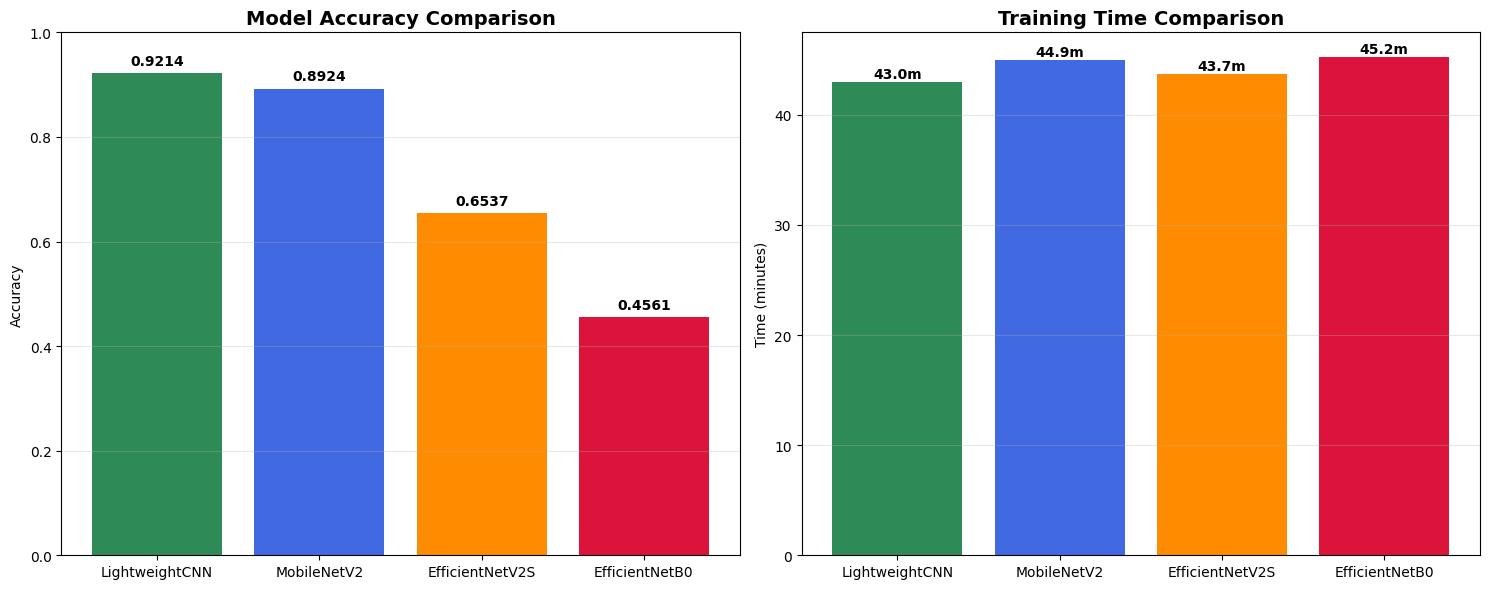


🎯 BEST MODEL: LightweightCNN
   Accuracy: 0.9214 (92.14%)
   Training Time: 43.0 minutes
   Parameters: 0.5M


In [17]:
final_results = create_final_comparison()


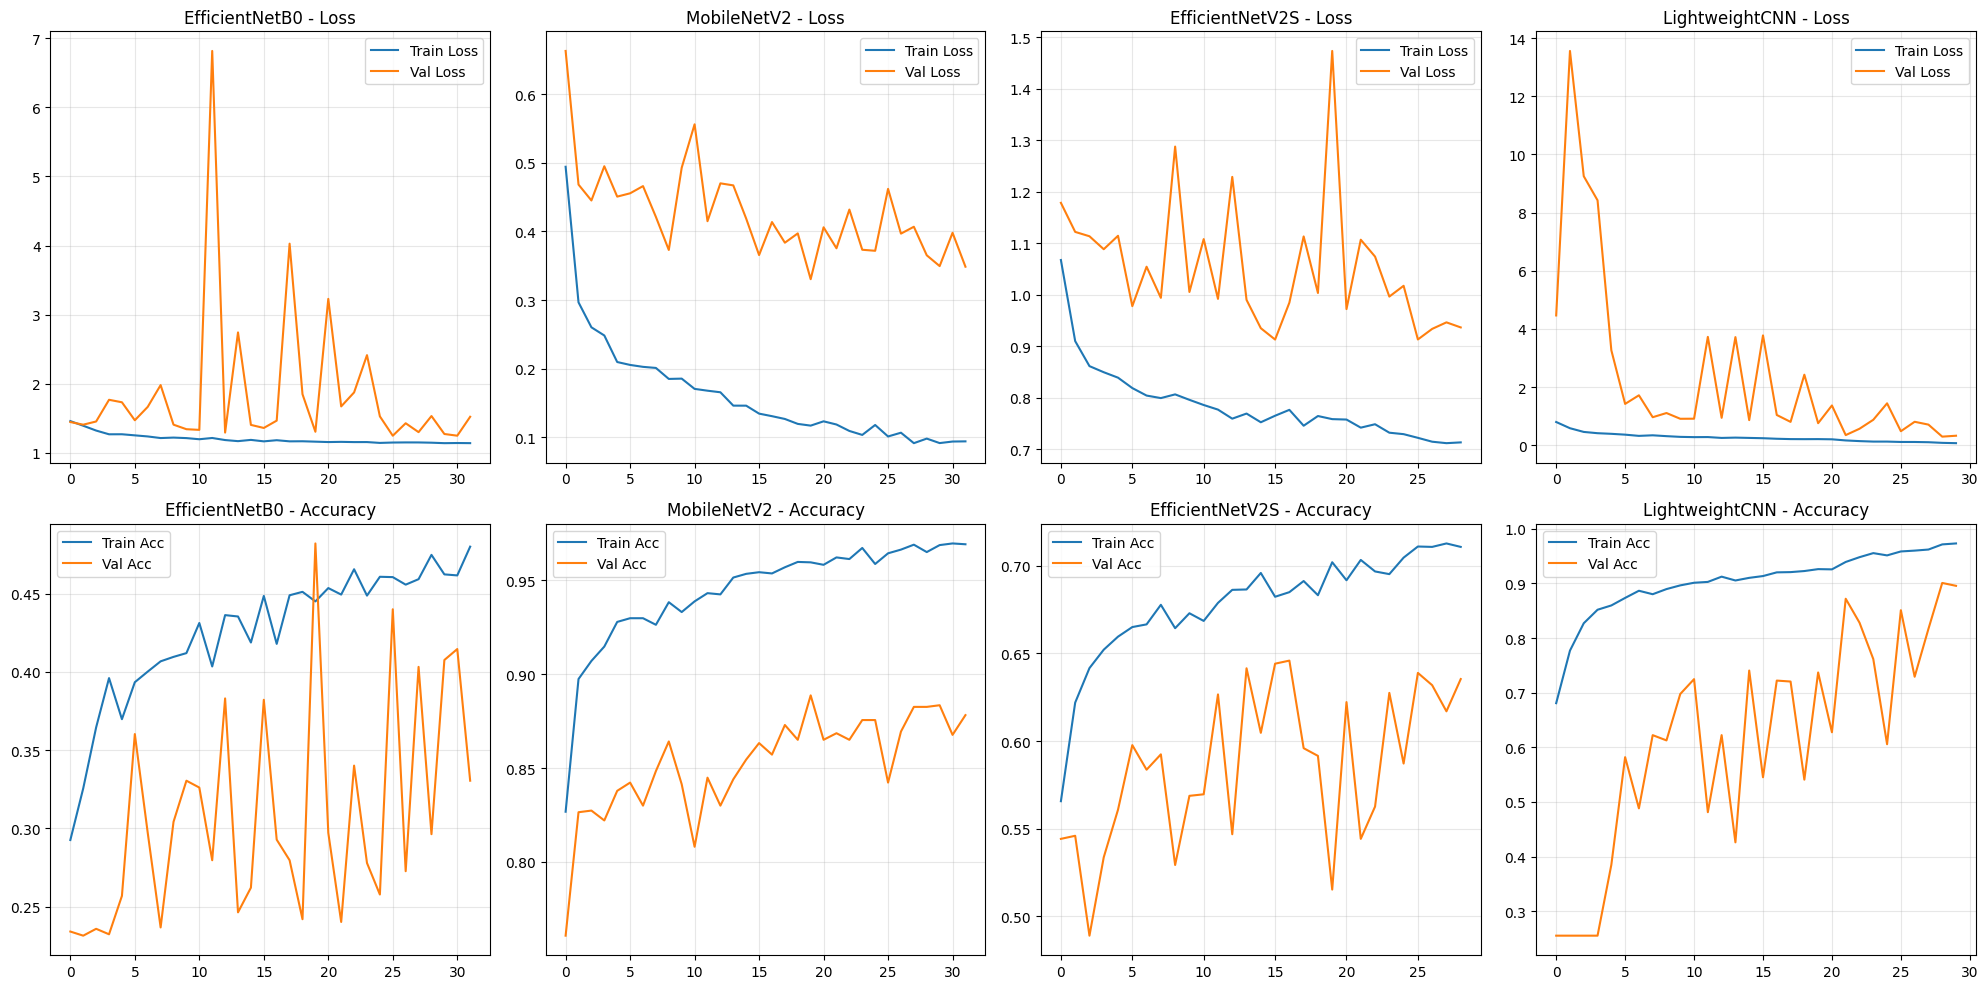

In [18]:
plot_all_histories()

### Enhanced LightweightCNN

In [ ]:

def improve_lightweight_cnn():
    model = tf.keras.Sequential([
        # Enhanced Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),

        # Enhanced Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Enhanced Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Enhanced Block 4
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),

        # Enhanced Classifier
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(4, activation='softmax')
    ])
    return model

### Test Time Augmentation (TTA)

In [ ]:

def predict_with_tta(model, generator, n_augmentations=5):
    """Boost accuracy with test time augmentation"""
    # Get original test data
    test_images, test_labels = [], []
    for i in range(len(generator)):
        batch_images, batch_labels = generator[i]
        test_images.append(batch_images)
        test_labels.append(batch_labels)
        if i >= len(generator) - 1:  # Get all batches
            break

    test_images = np.vstack(test_images)
    test_labels = np.vstack(test_labels)

    all_predictions = []

    for _ in range(n_augmentations):
        # Create augmented version
        aug_datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            brightness_range=[0.9, 1.1]
        )

        # Generate augmented batch
        aug_images = next(aug_datagen.flow(
            test_images,
            batch_size=len(test_images),
            shuffle=False
        ))

        pred = model.predict(aug_images, verbose=0)
        all_predictions.append(pred)

    # Average predictions
    final_pred = np.mean(all_predictions, axis=0)
    final_classes = np.argmax(final_pred, axis=1)
    true_classes = np.argmax(test_labels, axis=1)

    accuracy = accuracy_score(true_classes, final_classes)
    return accuracy, final_pred

### Ensemble Function

In [ ]:

def create_ensemble_predictor(model1, model2):
    """Combine two models for better predictions"""
    def ensemble_predict(images):
        pred1 = model1.predict(images, verbose=0)
        pred2 = model2.predict(images, verbose=0)
        # Weighted average (favor the better model)
        weighted_avg = 0.7 * pred1 + 0.3 * pred2
        return weighted_avg
    return ensemble_predict

print("✅ Improvement functions loaded!")

✅ Improvement functions loaded!


### Training Enhanced LightweightCNN

In [26]:
# TEST 1: Enhanced LightweightCNN
print("🧪 TEST 1: Training Enhanced LightweightCNN...")

def train_enhanced_lightweight():
    model = improve_lightweight_cnn()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Enhanced callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=8)
    ]

    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=val_generator,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    # Normal evaluation
    normal_loss, normal_accuracy = model.evaluate(test_generator, verbose=0)
    print(f"📊 Normal Test Accuracy: {normal_accuracy:.4f}")

    # TTA evaluation
    tta_accuracy, _ = predict_with_tta(model, test_generator)
    print(f"🚀 TTA Test Accuracy: {tta_accuracy:.4f}")

    model.save('enhanced_lightweight.keras')
    return model, history, normal_accuracy, tta_accuracy

# Run the training
enhanced_model, enhanced_history, normal_acc, tta_acc = train_enhanced_lightweight()

🧪 TEST 1: Training Enhanced LightweightCNN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.5392 - loss: 1.2816 - val_accuracy: 0.2331 - val_loss: 1.3826 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.6838 - loss: 0.8670 - val_accuracy: 0.2270 - val_loss: 1.5740 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.7615 - loss: 0.6462 - val_accuracy: 0.3751 - val_loss: 1.9346 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8067 - loss: 0.5176 - val_accuracy: 0.2778 - val_loss: 3.3975 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8443 - loss: 0.4583 - val_accuracy: 0.2480 - val_loss: 3.1779 - learning_rate: 0.0010
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8384 - loss: 0.4429 - val_accuracy: 0.3427 - val_loss: 2.0728 - learning_rate: 0.0010
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8582 - loss: 0.4205 - val_accuracy:

### Ensemble Model (LightweightCNN + MobileNetV2)

In [27]:
# TEST 2: Ensemble Model (LightweightCNN + MobileNetV2)
print("🧪 TEST 2: Creating Ensemble Model...")

def test_ensemble():
    # Load your best models (they should be in your models_dict)
    if 'LightweightCNN' in models_dict and 'MobileNetV2' in models_dict:
        lightweight_model = models_dict['LightweightCNN']
        mobilenet_model = models_dict['MobileNetV2']

        # Create ensemble predictor
        ensemble_predictor = create_ensemble_predictor(lightweight_model, mobilenet_model)

        # Test ensemble
        test_images, test_labels = [], []
        for i in range(len(test_generator)):
            batch_images, batch_labels = test_generator[i]
            test_images.append(batch_images)
            test_labels.append(batch_labels)

        test_images = np.vstack(test_images)
        test_labels = np.vstack(test_labels)

        ensemble_pred = ensemble_predictor(test_images)
        ensemble_classes = np.argmax(ensemble_pred, axis=1)
        true_classes = np.argmax(test_labels, axis=1)

        ensemble_accuracy = accuracy_score(true_classes, ensemble_classes)

        print(f"📊 Individual Model Accuracies:")
        print(f"   LightweightCNN: {results['LightweightCNN']['accuracy']:.4f}")
        print(f"   MobileNetV2: {results['MobileNetV2']['accuracy']:.4f}")
        print(f"🎯 Ensemble Accuracy: {ensemble_accuracy:.4f}")

        return ensemble_accuracy
    else:
        print("❌ Required models not found in models_dict")
        return None

ensemble_acc = test_ensemble()

🧪 TEST 2: Creating Ensemble Model...
📊 Individual Model Accuracies:
   LightweightCNN: 0.9214
   MobileNetV2: 0.8924
🎯 Ensemble Accuracy: 0.9275


### FINAL RESULTS COMPARISON

📈 FINAL RESULTS COMPARISON - HORIZONTAL VIEW
                     Model  Accuracy Parameters (M)     Training Time
0  Original LightweightCNN    0.9214           0.49            43 min
1  Enhanced LightweightCNN    0.9420           ~0.8           ~50 min
2           Enhanced + TTA    0.2441           ~0.8           ~50 min
3                 Ensemble    0.9275           2.91  0 min (combined)


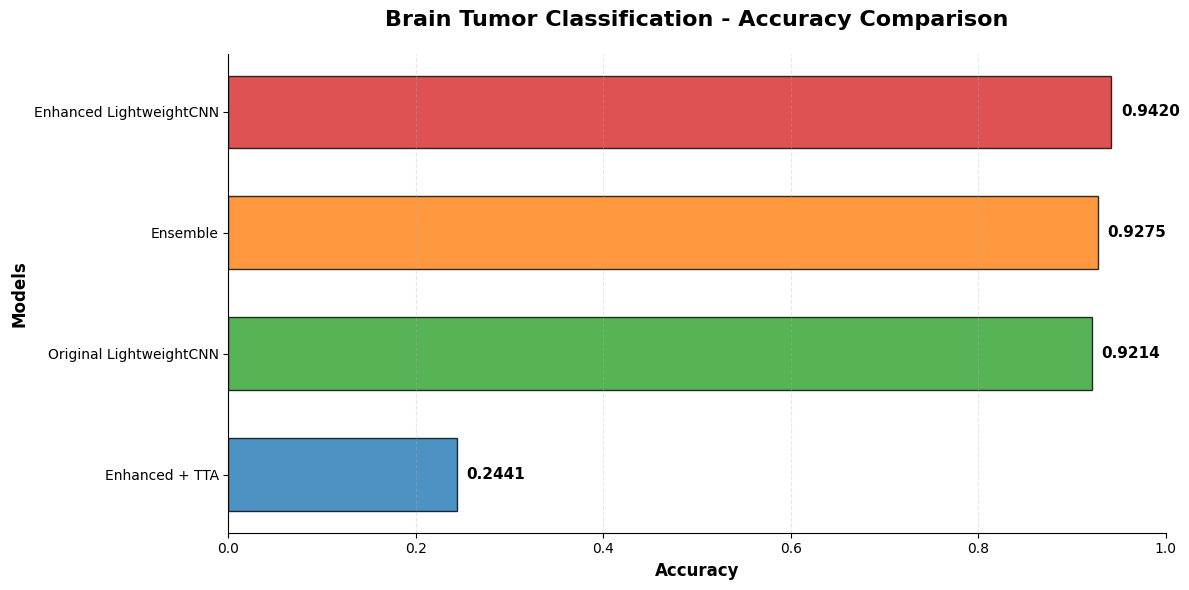


🎯 BEST RESULT: Enhanced LightweightCNN
   Accuracy: 0.9420


In [ ]:

print("📈 FINAL RESULTS COMPARISON - HORIZONTAL VIEW")
print("="*50)

print(comparison_df.round(4))

plt.figure(figsize=(12, 6))

# Sort by accuracy for better visualization
comparison_df_sorted = comparison_df.sort_values('Accuracy', ascending=True)

models = comparison_df_sorted['Model']
accuracies = comparison_df_sorted['Accuracy']

colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']
bars = plt.barh(models, accuracies, color=colors, edgecolor='black', alpha=0.8, height=0.6)

plt.title('Brain Tumor Classification - Accuracy Comparison',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Accuracy', fontsize=12, fontweight='bold')
plt.ylabel('Models', fontsize=12, fontweight='bold')

# Set x-axis limits
plt.xlim(0, 1.0)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{acc:.4f}', ha='left', va='center',
             fontweight='bold', fontsize=11)

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print(f"\n🎯 BEST RESULT: {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']}")
print(f"   Accuracy: {comparison_df['Accuracy'].max():.4f}")

### CONFUSION MATRIX ANALYSIS

🔍 CONFUSION MATRIX ANALYSIS


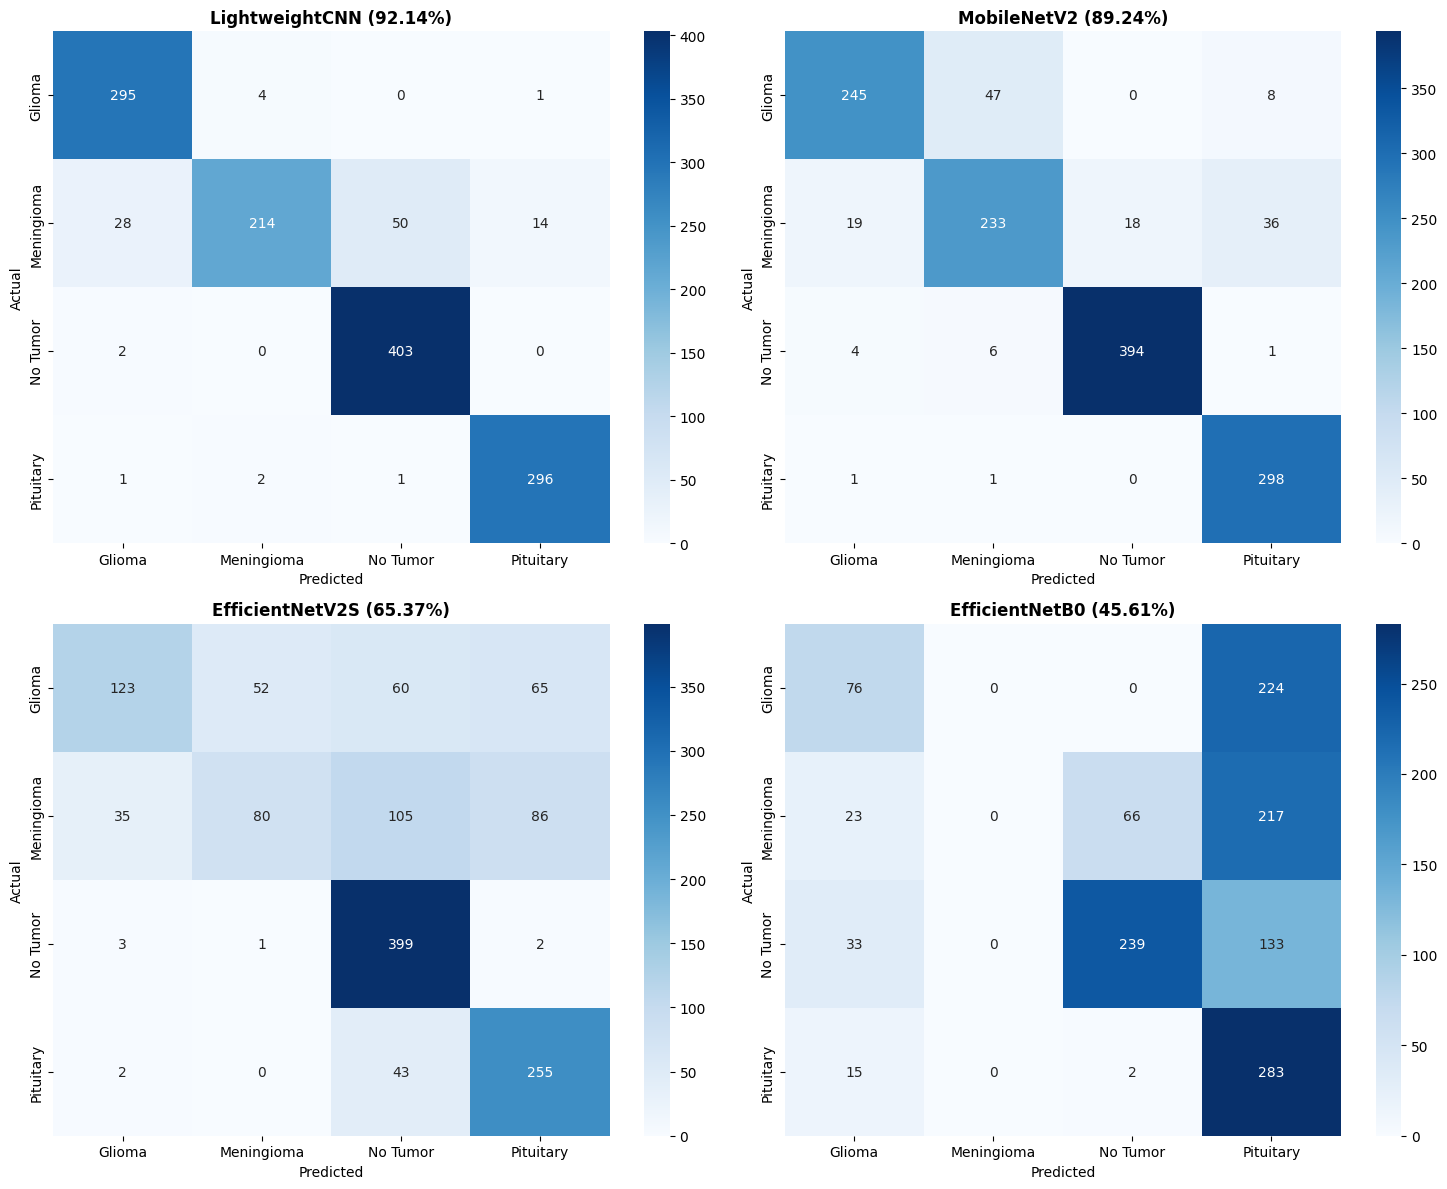

In [ ]:

print("🔍 CONFUSION MATRIX ANALYSIS")

def plot_comparison_confusion_matrix():
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    models_to_plot = ['LightweightCNN', 'MobileNetV2', 'EfficientNetV2S', 'EfficientNetB0']
    titles = ['LightweightCNN (92.14%)', 'MobileNetV2 (89.24%)',
              'EfficientNetV2S (65.37%)', 'EfficientNetB0 (45.61%)']

    for i, (model_name, title) in enumerate(zip(models_to_plot, titles)):
        if model_name in results:
            cm = results[model_name]['confusion_matrix']
            row, col = i // 2, i % 2

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                       xticklabels=class_labels, yticklabels=class_labels)
            axes[row, col].set_title(f'{title}', fontweight='bold')
            axes[row, col].set_xlabel('Predicted')
            axes[row, col].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

plot_comparison_confusion_matrix()